<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session1/EVA_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the necessary packages
import numpy as np
from urllib.request import urlopen
import cv2
from matplotlib import pyplot as plt

# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
	return image

In [0]:
image = url_to_image("https://fontsarena-cd5e.kxcdn.com/wp-content/uploads/2019/04/helvetica-now-font-400x364.png")

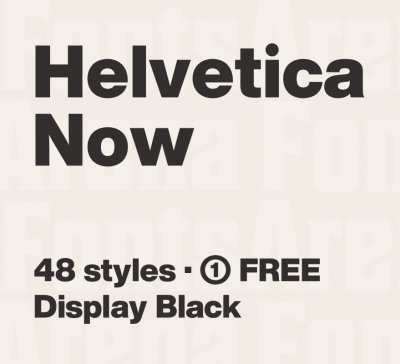

In [4]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [0]:
edges = cv2.Canny(image,100,200)

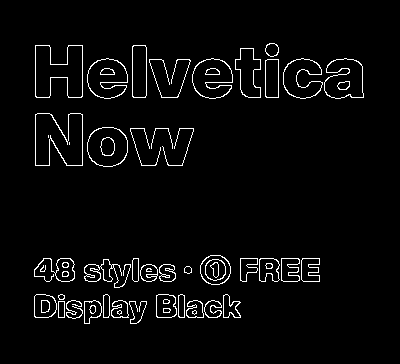

In [6]:
cv2_imshow(edges)


 DETECTING 45 DEGREE ANGLE (LEFT TO RIGHT) 

After applying kernel : 

[[ 6. -2. -2.]
 [-2.  6. -2.]
 [-2. -2.  6.]]

Result is : 



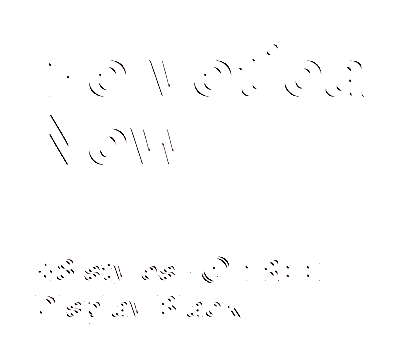


 DETECTING 45 DEGREE ANGLE (RIGHT TO LEFT) 

After applying kernel : 

[[-2. -2.  6.]
 [-2.  6. -2.]
 [ 6. -2. -2.]]

Result is : 



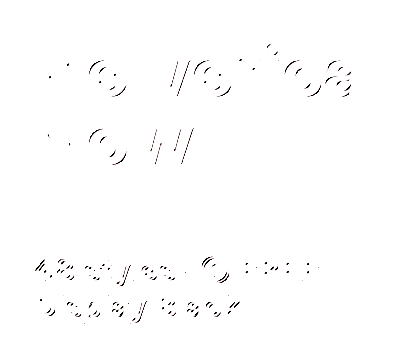

In [41]:
#kernel = np.ones((3,3),np.float32)/25
angle_detector_1 = np.float32([[6,-2,-2],
                               [-2,6,-2],
                               [-2,-2,6]])

angle_detector_2 = np.float32([[-2,-2,6],
                               [-2,6,-2],
                               [6,-2,-2]])
print("\n\033[1m DETECTING 45 DEGREE ANGLE (LEFT TO RIGHT) \033[0m")
print("\nAfter applying kernel : \n\n" + str(angle_detector_1))
print("\nResult is : \n")
dst = cv2.filter2D(image,-1,angle_detector_1)
cv2_imshow(dst)
print("\n\033[1m DETECTING 45 DEGREE ANGLE (RIGHT TO LEFT) \033[0m")
print("\nAfter applying kernel : \n\n" + str(angle_detector_2))
print("\nResult is : \n")
dst = cv2.filter2D(image,-1,angle_detector_2)
cv2_imshow(dst)


##Channels and Filters

In convolutional filters - the channels going into and out of a **kernel** are matrices or tensors. 

Every position (*x_out,Y_out*) of the output channel needs to then be indicative of the amplitude of the presence of a certain feature in certain positions (*x_in,y_in*)s of the input channels. That then must be the measurable criteria that any given filter can be marked on.

Given this criteria, we move towards our 45 deg angle edge detector filter. Since we are using 3x3 filters alone, each position (*x_out,y_out*) in the output channel must correspond to nine positions (*x_in,y_in*)s in the input image and we will be successfull if there O[**x,y**] will be maximized when I[**x1:x9,y1:y9**] contains a 45 degree edge and vice versa where:
 
I --> Input channel / Image

O --> Output Channel after applying our kernel

x1:x9,y1:y9 --> Local receptive field of O[x,y]

Okay - that said - Let us get to why the kernels were made as they were in the code above

###45 degree edge detector

Let us take a look at [this image](https://github.com/anubhavsatpathy/EVA/blob/master/Session1/images/channels.png) to explain this in detail since it is impossible to explore the other kernels with baby examples.

The input 5x5 image has only one channel - black means a higher amplitude of gray and white positions have a low amplitude of gray. Now then - lets zoom in on the 3x3 LRF on the filter(colored in red) in the first position. At each position the output is the sum-product of the  values in the filter with the corresponding values in the image. For our purposes it is obvious that we want this sum-product to be maximized at images 3, 5 and 7 and low for other positions. 

Hence it makes sense to allign the high values of our kernel with the high value of the image at these LRF positions. This intuition alone gives us the following candidate filter:



```
[[1,1,4],
 [1,4,1],
 [4,1,1]]
```
This acheives the job mentioned above - but imagine if the LFR positions of the image was a big bolt of dark gray (high values) - In that case the value of the sum product for this filter would be even higher that when there is just a 45 degree edge. We do not want that now do we? Well, one way of not having our filter misbehave thus, is to minimize(to the negative) the values of our filter at all positions except where we expect the high values to be in the case of our feature. Hence we evaluate the following


```
[[-1,-1,4],
 [-1,4,-1],
 [4,-1,-1]]
```

We tried that in the code above and BAM! Results just happened. Can we think of any examples where this would fail? Well what if the edge was oriented the other way ? In that case - we can always create two filters one for each orientation - Which is what we have done above in code! 



















 BLURRING 

After applying kernel : 

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Result is : 



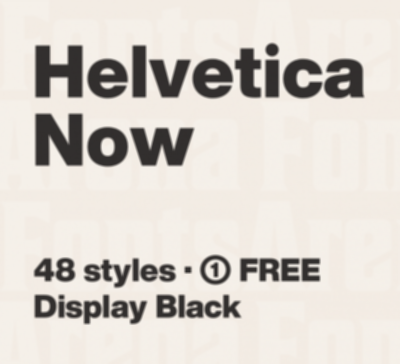


 SHARPENING 

After applying kernel : 

[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]

Result is : 



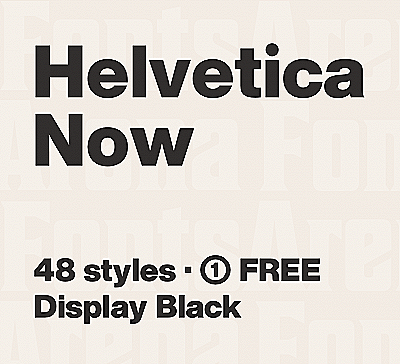

In [39]:
blur_kernel = (1/9)*np.float32([[1,1,1],
                         [1,1,1],
                         [1,1,1]])

#gaussian_blur_kernel = np.random.normal(size = (3,3))
gaussian_blur_kernel = np.float32([[ 1.06218928,  0.02602478,  1.17164951],
                                   [-2.07162076, -2.59687666,  1.62555188],
                                   [ 0.55847574,  0.31964844,  0.77771263]])

sharpen_kernel = np.float32([[0,-1,0],
                             [-1,5,-1],
                             [0,-1,0]])


print("\033[1m BLURRING \033[0m")
print("\nAfter applying kernel : \n\n" + str(blur_kernel))
print("\nResult is : \n")
dst = cv2.filter2D(image,-1,blur_kernel)
cv2_imshow(dst)
print("\n\033[1m SHARPENING \033[0m")
print("\nAfter applying kernel : \n\n" + str(sharpen_kernel))
print("\nResult is : \n")
dst = cv2.filter2D(image,-1,sharpen_kernel)
cv2_imshow(dst)



###Blur & Sharpener Kernels

For making a blur kernel or a sharpening kernel we need to first define quantitatively the meanings of **blur** and **sharpen**

**Blur** simply means an aversion to a sudden change in amplitude of a channel. So Suppose position [0,0] has a value of 250 and position [0,1] has a value of 23 - well that aint what what our blur filter would let pass. This sudden change in amplitude is referred to as high frequency in the context of images

**Sharpen** simply means an unconditional appreciation of this higher frequencies in images.

So a blur filter would not like certain positions in it's LRF to be of low values and others to be of a very high value - hence an appropriate operation for the blur filter would be if it could output for such LFRs that average of the input values. This is exactly what is acheived in the *blur_kernel* above.

A sharpen filter of the other hand loves higher frequencies - So Its output should magnify the differences in adjoining positions of it's LRF. Hence - we increase the value in the centre of the kernel and reduce the values in the exterior. This is exactly what has been done in the code above.

However - one might ask why the corner elements of the kernal are left 0 and not reduced to negatives. Well in doing that what we end up doing is not allowing low frequency ranges to pass at all - Hence the only sections of the image that will pass through this kernel will be edges - It is the extreme case of a high pass or a sharpener kernel 




 DOING NOTHING - IDENTITY 

After applying kernel : 

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

Result is : 



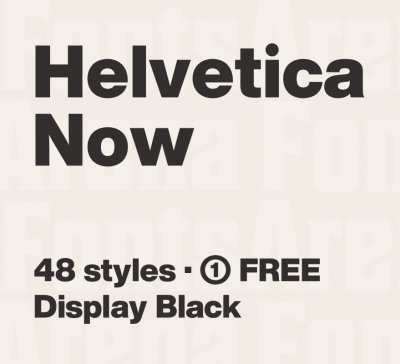

In [40]:
identity_kernel = np.float32([[0,0,0],
                              [0,1,0],
                              [0,0,0]])

print("\n\033[1m DOING NOTHING - IDENTITY \033[0m")
print("\nAfter applying kernel : \n\n" + str(identity_kernel))
print("\nResult is : \n")
dst = cv2.filter2D(image,-1,identity_kernel)
cv2_imshow(dst)

###Identity Kernel

The idea of the identity kernel is to do nothing to the image - All ones? Well that would mean the output is the sum of the LRF of the kernel - kind of what blur might want to do - definitely not an identity

What if we use the sharpening filter but not reduce the 4 negative positions to negatives - instead keep them 0. In doing this what we are doing at each convolution position is simply outputting the the centre of the LRF of the kernel. 

In a large enough image this would work as an identity since :

1. We are using a 3x3 kernel 
2. We use a stride of one

This ensures that we do not skip over some significant features in a large enough image with broad strokes.